<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C3/C3.html"><img src="../data/C3_nav.png" width="100"  style="float:right;" alt="C3"></a>
<h1> Music Synchronization</h1> 
</div>

<br/>

<p>
In this notebook, we give an example for music synchronization following Chapter 3 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a>. For technical details we refer to Section 3.1 (Audio Features) and Section 3.2 (Dynamic Time Warping).
</p> 

## Introduction

Music can be described and represented in many different ways including sheet music, symbolic representations, and audio recordings. For each of these representations, there may exist different versions that correspond to the same musical work. For example, for Beethoven's Fifth Symphony one can find a large number of music recordings performed by different orchestras and conductors. As our main example in this notebook, we consider the beginning of Beethoven's Fifth Symphony (first 21 measures) as shown below in form of a piano-reduced version (for a full score, we refer to the <a href="../C1/C1S1_SheetMusic.html">FMP notebook on Sheet Music Representations</a>. Let us listen to two different recordings. The first recording is a synthesized version of a piano-reduced score, whereas the second recording is an interpretation by the Vienna Philharmonic Orchestra conducted by Herbert von Karajan, 1946.

<img src="../data/C3/FMP_C3S3_Beethoven_Fifth-MM1-21_Sibelius-Piano.png" width="700px" align="left" alt="C1">

<br clear="all" />

<audio src="../data/C3/FMP_C3S3_Beethoven_Fifth-MM1-21_Midi-Piano.mp3" type="audio/mpeg" controls="controls"></audio>
<audio src="../data/C3/FMP_C3S3_Beethoven_Fifth-MM1-21_Karajan1946.mp3" type="audio/mpeg" controls="controls"></audio>

Given two different music representations, typical synchronization approaches proceed in two steps.

* In the first step, the two representations are transformed into sequences of suitable features. In general, such feature representations need to find  a compromise between two conflicting goals. On the one hand, features should show a large degree of robustness to variations that are to be left unconsidered for the task at hand. On the other hand, features should capture enough characteristic information  to accomplish the given task. In the following, we use [**chroma-based features**](../C3/C3S1_SpecLogFreq-Chromagram.html), which capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation. 

* In the second step, the derived feature sequences have to be brought into temporal correspondence. To this end, one may use [**dynamic time warping**](../C3/C3S2_DTWbasic.html) (DTW) for computes an optimal alignment between two given feature sequences. This alignment constitutes our synchronization result.

The following figure gives an overview of this two-step processing pipeline.

<img src="../data/C3/FMP_C3_F02.png" width="600px" align="center" alt="C3">

## Chroma-Based Feature Representation

To compare the two recordings, we convert the audio signals into sequences of chroma vectors. In the following, we use the Python package `librosa` to load and process the audio recordings. Starting with the sampling rate $F_\mathrm{s}=22050$ Hz, we use an STFT using a window length of $N=4410$ and a hop size of $H=2205$ samples. This results in feature sequences of $10$ features per seconds (feature resolution of $10$ Hertz). Furthermore, the chroma features are [normalized](../C3/C3S1_FeatureNormalization.html) with respect to the $\ell^2$-norm.

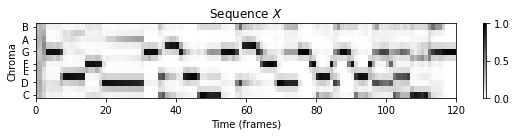

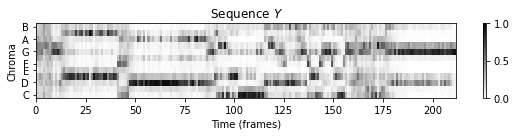

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
%matplotlib inline

import sys
sys.path.append('..')
import libfmp.c3

Fs = 22050
fn_wav_X = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Beethoven_Fifth-MM1-21_Midi-Piano.wav')
fn_wav_Y = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Beethoven_Fifth-MM1-21_Karajan1946.wav')
X_wav, Fs = librosa.load(fn_wav_X, sr=Fs)
Y_wav, Fs = librosa.load(fn_wav_Y, sr=Fs)

N = 4410
H = 2205
X = librosa.feature.chroma_stft(y=X_wav, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
Y = librosa.feature.chroma_stft(y=Y_wav, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)

plt.figure(figsize=(8, 2))
plt.title('Sequence $X$')
librosa.display.specshow(X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()
ipd.display(ipd.Audio(X_wav, rate=Fs))

plt.figure(figsize=(8, 2))
plt.title('Sequence $Y$')
librosa.display.specshow(Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()
ipd.display(ipd.Audio(Y_wav, rate=Fs))

## Application of DTW

Next, we compute the cost matrix $C$ based on the Euclidean distance, then the accumulated cost matrix $D$ using dynamic programming, and finally an optimal warping path $P^\ast$ using backtracking. We visualize the cost matrix $C$ and the accumulated cost matrix $D$ along with the optimal warping path (indicated by the red dots).

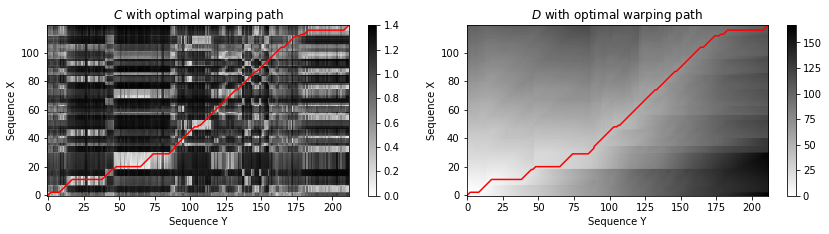

In [2]:
C = libfmp.c3.compute_cost_matrix(X, Y)
D = libfmp.c3.compute_accumulated_cost_matrix(C)
P = libfmp.c3.compute_optimal_warping_path(D)


plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
libfmp.c3.plot_matrix_with_points(C, P, linestyle='-',  marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(C)], 
    title='$C$ with optimal warping path', xlabel='Sequence Y', ylabel='Sequence X');

ax = plt.subplot(1, 2, 2)
libfmp.c3.plot_matrix_with_points(D, P, linestyle='-', marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(D)], 
    title='$D$ with optimal warping path', xlabel='Sequence Y', ylabel='Sequence X');

plt.tight_layout()

Finally, we give some alternative for visualizing the final result of the alignment.

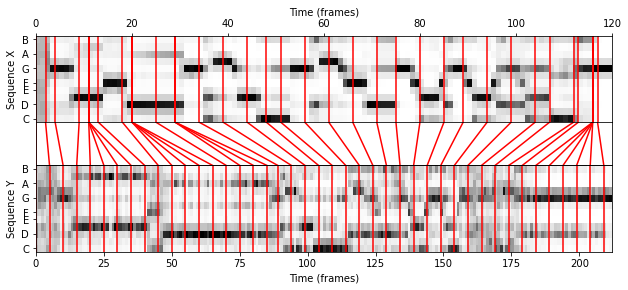

In [3]:
N = X.shape[1]
M = Y.shape[1]

plt.figure(figsize=(8, 3))
#plt.figure(figsize=(5, 3)) 
ax_X = plt.axes([0, 0.60, 1, 0.40])
librosa.display.specshow(X, ax=ax_X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
ax_X.set_ylabel('Sequence X')
ax_X.set_xlabel('Time (frames)')
ax_X.xaxis.tick_top()
ax_X.xaxis.set_label_position('top') 

ax_Y = plt.axes([0, 0, 1, 0.40])
librosa.display.specshow(Y, ax=ax_Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
ax_Y.set_ylabel('Sequence Y')
ax_Y.set_xlabel('Time (frames)')

step = 5
y_min_X, y_max_X = ax_X.get_ylim()
y_min_Y, y_max_Y = ax_Y.get_ylim()
for t in P[0:-1:step, :]: 
    ax_X.vlines(t[0], y_min_X, y_max_X, color='r')
    ax_Y.vlines(t[1], y_min_Y, y_max_Y, color='r')

ax = plt.axes([0, 0.40, 1, 0.20])
for p in P[0:-1:step, :]: 
    ax.plot((p[0]/N, p[1]/M), (1, -1), color='r')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([]);

## Further Notes

In this notebook, we introduced a basic approach for synchronizing different recordings of the same piece of music. Music synchronization and related alignment tasks have been studied extensively within the field of music information retrieval. Depending upon the respective types of music representations, one can distinguish between various synchronization scenarios including:

* **Audio-audio synchronization**: Alignment of two music recordings (as discussed in this notebook).
* **Score-audio synchronization**: Alignment of symbolically encoded score events with time positions in a recording.
* **Image-audio synchronization**: Alignment of spatial positions (e.g., bounding boxes of musical measures given in pixels) of digitized images of sheet music with time positions of a recording.
* **Lyrics-audio synchronization**: Alignment of lyrics (given in text format) with time positions of a recorded song. 

In the above-mentioned synchronization scenarios, the two data streams to be aligned are assumed to be known  prior to the actual alignment. This assumption is exploited by DTW, which yields an optimal warping path by considering the two entire data streams. As opposed to such an **offline** scenario, one often has to deal with scenarios where the data streams are to be processed **online**. One prominent online scenario is known as **score following**, where a musician is performing a piece according to a given musical score. The goal is then to identify the currently played musical events depicted in the score with high accuracy and low latency.

There are many more variants of cross-modal alignment and matching tasks, and there are many more issues that need to be considered in the music synchronization context including robustness, accuracy, and efficiency. For further reading, we refer to <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a> and the literature below. As examples, we briefly address two of these aspects.

* Given a score representation and a recorded performance of the same piece of music, the task of **score-performance synchronization** is to temporally align musical sections such as measures specified by the score to temporal sections in the performance. One challenge in this scenario is that a performer may deviate from the score by ignoring a repeat or introducing an additional repeat that is not written in the score. Fremerey et al. introduce a DTW-variant that can cope with such structural differences.

* In the design of synchronization algorithms, one has to deal with a delicate tradeoff between robustness and temporal accuracy. Ewert et al. introduce a novel class of $12$-dimensional onset features, which combine the robustness of conventional [chroma features](../C3/C3S1_SpecLogFreq-Chromagram.html) with the accuracy of conventional one-dimensional [onset feature](../C6/C6S1_OnsetDetection.html). In particular, their synchronization framework allows for improving the overall synchronization accuracy without losing robustness.

## Literature

<ul>  
<li><span style="color:black">
Meinard Müller and Masataka Goto and Markus Schedl: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2012_MuellerGS_MultimodalMusicProcessing_DagstuhlFU.pdf"><strong>Multimodal Music Processing.</strong></a> Dagstuhl Follow-Ups, Schloss Dagstuhl - Leibniz-Zentrum für Informatik, Germany, 3, 2012.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerGS12_MultimodalMusicProcessing_DagstuhlFU.txt"> Bibtex </a>
</span></li>

<li><span style="color:black">
Meinard Müller, Bryan Pardo, Gautham J. Mysore, and Vesa Välimäki: <a href="https://ieeexplore.ieee.org/document/8588415"><strong>Recent Advances in Music Signal Processing.</strong></a> IEEE Signal Processing Magazine, 36(1): 17–19, 2019.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MullerPMV19_Editorial_IEEE-SPM.txt"> Bibtex </a>
</span></li>
    
<li><span style="color:black">
Christian Fremerey, Meinard Müller, and Michael Clausen: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2010_FremereyMuellerClausen_PartialSync_ISMIR.pdf"><strong>Handling Repeats and Jumps in Score-Performance Synchronization.</strong></a> Proceedings of the International Conference on Music Information Retrieval (ISMIR): 243–248, 2010. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_FremereyMC10_RepeatsJumps_ISMIR.txt"> Bibtex </a>
</span></li>

<li><span style="color:black">
Sebastian Ewert, Meinard Müller, and Peter Grosche:  <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2009_EwertMuellerGrosche_HighResAudioSync_ICASSP.pdf"><strong>High Resolution Audio Synchronization Using Chroma Onset Features.</strong></a> Proceedings of IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP): 1869–1872, 2009.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_EwertMG09_HighResAudioSync_ICASSP.txt"> Bibtex </a>
</span></li>
    
</ul>   

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/balke">Stefan Balke</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>